In [67]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11,8)})
from pathlib import Path
from spellchecker import SpellChecker
import string


DATA = Path.cwd().parent / 'data' 
EFCAMDAT = DATA / 'efcamdat_shatz_distro.parquet'

In [2]:
df = pd.read_parquet(EFCAMDAT)

In [3]:
df.shape

(723282, 25)

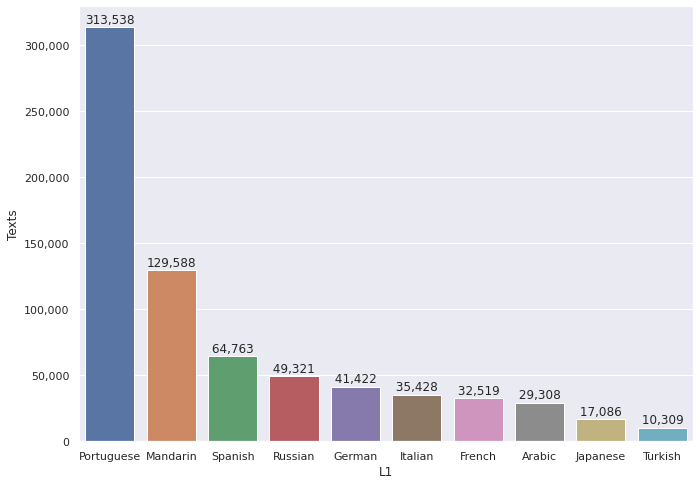

In [4]:
comma_formatter = lambda x, _: f'{x:,.0f}'
fig = sns.countplot(x=df.l1,
                    order=df.l1.value_counts().sort_values(ascending=False).index)
fig.axes.yaxis.set_major_formatter(comma_formatter)
for p in fig.patches:
    fig.annotate('{: >7,}'.format(p.get_height()), (p.get_x(), p.get_height()+3000))
fig.set(xlabel='L1', ylabel='Texts')
plt.savefig(Path.cwd().parent / 'images' / 'texts-by-language-bar.png')

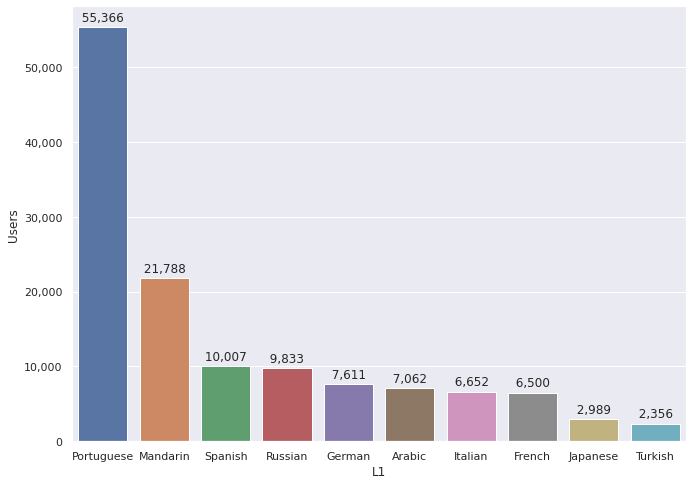

In [5]:
fig = sns.barplot(data=df.groupby(['l1']).learner_id.nunique().sort_values(ascending=False).to_frame().reset_index(), x='l1', y='learner_id')
fig.axes.yaxis.set_major_formatter(comma_formatter)
for p in fig.patches:
    fig.annotate('{: >7,}'.format(int(p.get_height())), (p.get_x(), p.get_height()+800))
fig.set(xlabel='L1', ylabel='Users')
plt.savefig(Path.cwd().parent / 'images' / 'users-by-language-bar.png')

In [73]:
df.columns

Index(['writing_id', 'learner_id', 'learner_id_categorical', 'nationality',
       'l1', 'cefr', 'cefr_numeric', 'level', 'unit', 'topic_id_original',
       'topic_id_original_categorical', 'topic_id', 'topic_id_categorical',
       'text_number_per_learner_in_task', 'topic', 'secondary_topic',
       'topic_to_keep', 'date', 'time', 'grade', 'wordcount', 'mtld', 'text',
       'text_corrected', 'sample', 'num_misspellings'],
      dtype='object')

<AxesSubplot:xlabel='level', ylabel='wordcount'>

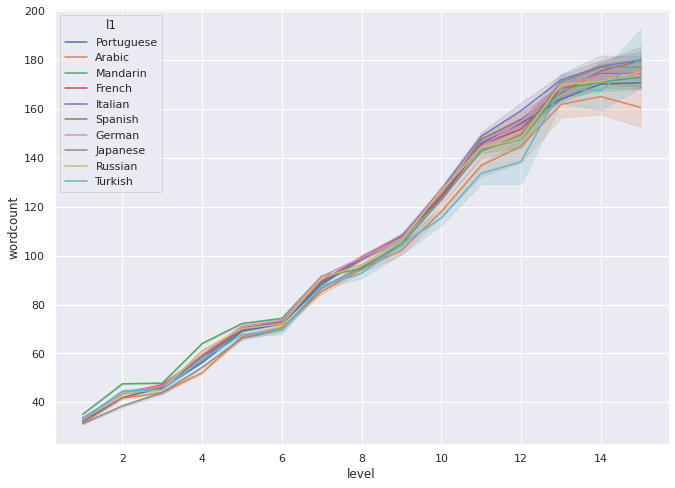

In [48]:
sns.lineplot(data=df.reset_index(), x='level', y='wordcount', hue='l1')

In [70]:
def countMisspellings(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    word_list = text.split()
    # find those words that may be misspelled
    misspelled = spell.unknown(word_list)
    return len(misspelled)
spell = SpellChecker()

df['num_misspellings'] = df['text'].apply(lambda x: countMisspellings(x))
df['misspellings_ratio'] = df['num_misspellings']/df['wordcount']

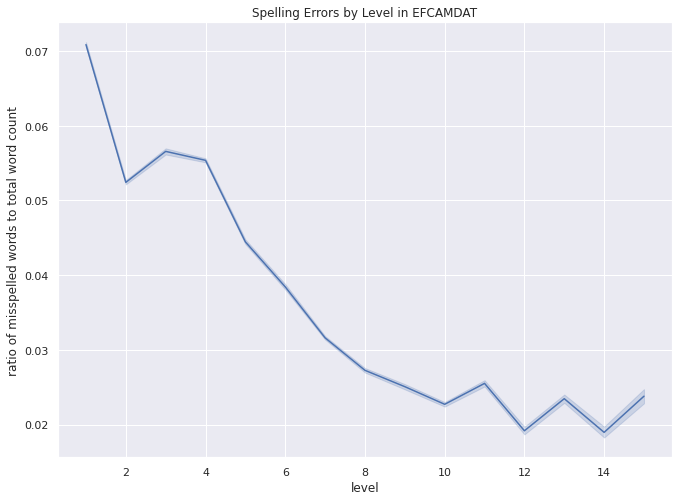

In [79]:
sns.lineplot(data=df.reset_index(), x='level', y='misspellings_ratio')
plt.title('Spelling Errors by Level in EFCAMDAT')
plt.ylabel('ratio of misspelled words to total word count')
plt.show()

Text(0.5, 1.0, 'Total Word Count by Level')

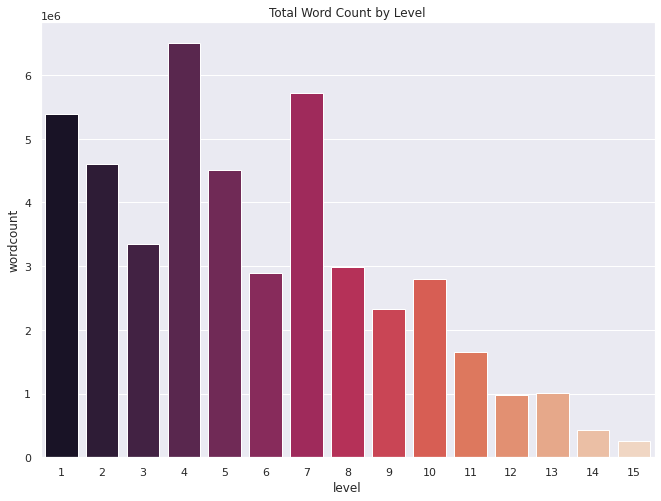

In [94]:
sns.color_palette("rocket", as_cmap=True)
sns.barplot(data = df.groupby('level').wordcount.sum().to_frame().reset_index(), x='level', y='wordcount', palette='rocket')
plt.title('Total Word Count by Level')

Text(0.5, 1.0, 'Counts of Essays by Level')

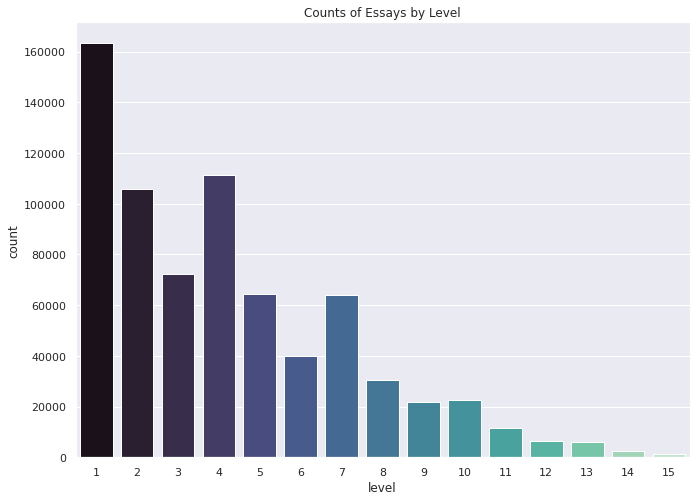

In [96]:
sns.countplot(data = df, x='level', palette='mako')
plt.title('Counts of Essays by Level')

<AxesSubplot:xlabel='l1', ylabel='misspellings_ratio'>

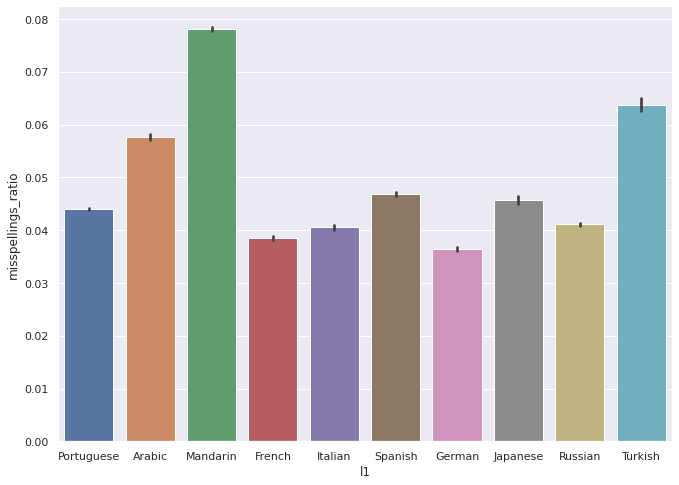

In [97]:
sns.barplot(data=df, x='l1', y='misspellings_ratio')

Text(0.5, 1.0, 'Number of Essays from each L1 by Level')

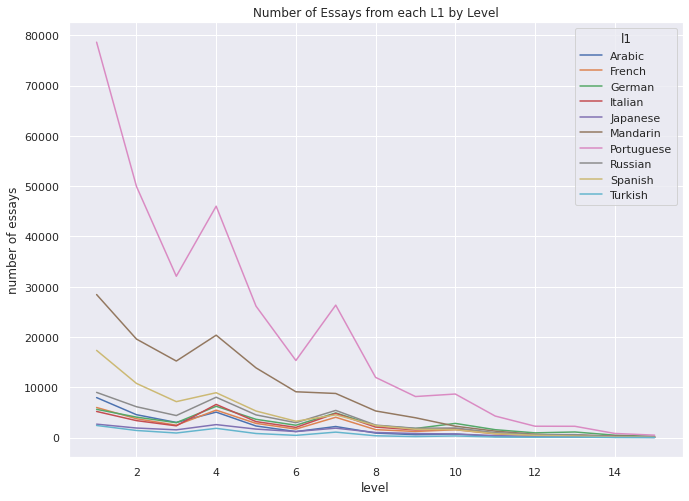

In [106]:
sns.lineplot(data=df.groupby(['l1', 'level']).learner_id.count().reset_index(), x='level', y='learner_id', hue='l1')
plt.ylabel('number of essays')
plt.title('Number of Essays from each L1 by Level')

In [128]:
from statsmodels.formula.api import ols

df.groupby(['level', 'l1']).learner_id.count().reset_index()

model = ols("learner_id ~ l1*level", data=df.groupby(['level', 'l1']).learner_id.count().reset_index())
results = model.fit()

In [129]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             learner_id   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     46.08
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           2.18e-48
Time:                        22:02:21   Log-Likelihood:                -1435.8
No. Observations:                 150   AIC:                             2912.
Df Residuals:                     130   BIC:                             2972.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5524.8667   2027.955      2.724      0.007    1512.801    9536.932
l1[T.French]            -417.8762   2867.961     -0.146      0.884   -6091.794    5256.042
l1[T.German]              38.2000   2867.961      0.013      0.989   -5635.718    5712.118
l1[T.Italian]           -361.7143   2867.961     -0.126      0.900   -6035.632    5312.204
l1[T.Japanese]         -2915.3143   2867.961     -1.017      0.311   -8589.232    2758.604
l1[T.Mandarin]           1.81e+04   2867.961      6.310      0.000    1.24e+04    2.38e+04
l1[T.Portuguese]        5.146e+04   2867.961     17.944      0.000    4.58e+04    5.71e+04
l1[T.Russian]           2410.0857   2867.961      0.840      0.402   -3263.832    8084.004
l1[T.Spanish]           6583.5238   2867.961      2.296      0.023     909.606    1.23e+04
l1[T.Turkish]          -3711.1714   2867.961     -1.294      0.198   -9385.089    1962.746
level                   -446.3750    223.045     -2.001      0.047    -887.643      -5.107
l1[T.French]:level        78.9929    315.434      0.250      0.803    -545.055     703.041
l1[T.German]:level        96.1750    315.434      0.305      0.761    -527.873     720.223
l1[T.Italian]:level       96.2143    315.434      0.305      0.761    -527.833     720.262
l1[T.Japanese]:level     262.5643    315.434      0.832      0.407    -361.483     886.612
l1[T.Mandarin]:level   -1426.5964    315.434     -4.523      0.000   -2050.644    -802.549
l1[T.Portuguese]:level -4064.2679    315.434    -12.885      0.000   -4688.316   -3440.220
l1[T.Russian]:level     -134.4857    315.434     -0.426      0.671    -758.533     489.562
l1[T.Spanish]:level     -527.4821    315.434     -1.672      0.097   -1151.530      96.566
l1[T.Turkish]:level      305.5714    315.434      0.969      0.334    -318.476     929.619
==============================================================================
Omnibus:                      116.863   Durbin-Watson:                   1.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3478.100
Skew:                           2.260   Prob(JB):                         0.00
Kurtosis:                      26.153   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
import spacy
nlp = spacy.load("en_core_web_sm")

df['vector'] = df['text'].apply(lambda x: nlp(x).vector)